In [1]:
import functools
import warnings

from sklearn import metrics
import numpy as np
from classes.boosting_matrix import BoostingMatrix
from classes.dataset import Dataset
from settings import Settings
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
from classes.pattern_boosting import PatternBoosting
from settings import Settings
from classes.enumeration.estimation_type import EstimationType
from data.synthetic_dataset import SyntheticDataset
import pandas as pd
import copy
from classes.analysis_patternboosting import AnalysisPatternBoosting
from data.load_dataset import load_dataset
from data import data_reader
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from multiprocessing.dummy import Pool as ThreadPool

import copy
from data import data_reader
from classes.wrapper_pattern_boosting import WrapperPatternBoosting
from jupiter_notebook_functions import *
import warnings
from typing import List, Tuple, Optional
from classes.analysis_wrapper_pattern_boosting import AnalysisWrapperPatternBoosting


In [3]:
# Settings

dataset_name = "5_k_selection_graphs"

# the model will be searched in the directory results/jupiter
pattern_boosting_model_name = "frequency_matrix"

max_n_learners = 1000

max_path_length = [2, 5]

max_depth = 1

errors_test_list = []
errors_train_list = []
n_learners_list = []
labels_list = []

print("Done")

Done


In [32]:
# run classical XGB with depth 1 using different number of learners, parallelize over the max length paths
print("run classical XGB with depth 1 using different number of learners")

# Load the dataset with the matrix with all possible paths

try:
    old_n_learners_limited_path_xgb = data_reader.load_data(directory="results/jupiter/plot",
                                                            filename="old_n_learners_limited_path_xgb")
except:
    warnings.warn("Old number of learners not found")
    old_n_learners_limited_path_xgb = 0
if max_n_learners >= old_n_learners_limited_path_xgb:

    directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
    pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_all_paths")

    dataset = load_dataset(dataset_name)

    # get the frequency matrix
    print("get the frequency matrix")
    '''
    if isinstance(pattern_boosting, PatternBoosting):
        frequency_matrix = pattern_boosting.create_boosting_matrix_for(dataset)

    elif isinstance(pattern_boosting, WrapperPatternBoosting):
        frequency_matrix = pattern_boosting.create_ordered_boosting_matrix(dataset)
    '''
    frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                    columns=pattern_boosting.boosting_matrix.get_header())

    print(len(pattern_boosting.boosting_matrix.get_header()))

    # run classical XGB with depth 1 using different number of learners, parallelize over the max length paths
    print("run classical XGB with depth 1 using different number of learners")
    pool = ThreadPool(min(10, len(max_path_length)))

    xgb_err = pool.map(
        functools.partial(get_XGB_error_and_variable_importance,
                          frequency_matrix=copy.deepcopy(frequency_matrix),
                          labels=dataset.labels,
                          max_number_of_learners=max_n_learners),
        max_path_length)

    xgb_test_err, xgb_train_err = zip(*xgb_err)

    # saving the errors

    data_reader.save_data(max_n_learners, filename="old_n_learners_limited_path_xgb", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(xgb_test_err, filename="test_err_limited_path_xgb",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(xgb_train_err, filename="train_err_limited_path_xgb",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)

    labels_list_limited_path_xgb = []
    for i, length in enumerate(max_path_length):
        n_learners_list.append(list(range(1, len(xgb_train_err[i]) + 1)))
        labels_list_limited_path_xgb.append('XGB path ' + str(length))

    data_reader.save_data(n_learners_list, filename="number_of_learners_limited_path_xgb",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)

    data_reader.save_data(labels_list_limited_path_xgb, filename="labels_list_limited_path_xgb",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)


run classical XGB with depth 1 using different number of learners
get the frequency matrix
98563
run classical XGB with depth 1 using different number of learners
[0]	validation_0-rmse:0.03166	validation_1-rmse:0.03054
[1]	validation_0-rmse:0.03154	validation_1-rmse:0.03048
[2]	validation_0-rmse:0.03142	validation_1-rmse:0.03039
[3]	validation_0-rmse:0.03132	validation_1-rmse:0.03032
[4]	validation_0-rmse:0.03123	validation_1-rmse:0.03022
[5]	validation_0-rmse:0.03115	validation_1-rmse:0.03022
[6]	validation_0-rmse:0.03107	validation_1-rmse:0.03009
[7]	validation_0-rmse:0.03100	validation_1-rmse:0.03001
[8]	validation_0-rmse:0.03092	validation_1-rmse:0.03001
[9]	validation_0-rmse:0.03086	validation_1-rmse:0.02998
[10]	validation_0-rmse:0.03079	validation_1-rmse:0.02990
[11]	validation_0-rmse:0.03073	validation_1-rmse:0.02983
[12]	validation_0-rmse:0.03067	validation_1-rmse:0.02981
[13]	validation_0-rmse:0.03061	validation_1-rmse:0.02972
[14]	validation_0-rmse:0.03055	validation_1-rmse:

In [33]:
# Run xgb full power and on the frequency matrix with all possible paths
print("Run xgb full power and on the frequency matrix with all possible paths")

try:
    old_n_learners_full_xgb_full_matrix = data_reader.load_data(directory="results/jupiter/plot",
                                                                filename="old_n_learners_full_xgb_full_matrix")
except:
    warnings.warn("Old number of learners not found")
    old_n_learners_full_xgb_full_matrix = 0
if max_n_learners >= old_n_learners_full_xgb_full_matrix:
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
    pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_all_paths")

    dataset = load_dataset(dataset_name)

    frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                    columns=pattern_boosting.boosting_matrix.get_header())

    xgb_settings = Settings.xgb_model_parameters
    xgb_settings['max_depth'] = max_depth

    xgb_settings = Settings.xgb_model_parameters
    xgb_settings['max_depth'] = max_depth
    test_err_full_power_xgb, train_err_full_power_xgb= get_XGB_error_and_variable_importance(
        max_path_length=200,
        frequency_matrix=copy.deepcopy(frequency_matrix),
        labels=dataset.labels,
        max_number_of_learners=max_n_learners,
        xgb_settings=xgb_settings)

    # saving the errors

    data_reader.save_data(max_n_learners, filename="old_n_learners_full_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(test_err_full_power_xgb, filename="test_err_full_power_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(train_err_full_power_xgb, filename="train_err_full_power_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(list(range(1, len(test_err_full_power_xgb) + 1)), filename="number_of_learners_full_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data('XGB depth ' + str(max_depth) + ' on all paths', filename="labels_list_full_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)



Run xgb full power and on the frequency matrix with all possible paths
[0]	validation_0-rmse:0.03163	validation_1-rmse:0.03053
[1]	validation_0-rmse:0.03144	validation_1-rmse:0.03044
[2]	validation_0-rmse:0.03129	validation_1-rmse:0.03037
[3]	validation_0-rmse:0.03116	validation_1-rmse:0.03026
[4]	validation_0-rmse:0.03103	validation_1-rmse:0.03013
[5]	validation_0-rmse:0.03091	validation_1-rmse:0.03000
[6]	validation_0-rmse:0.03079	validation_1-rmse:0.02991
[7]	validation_0-rmse:0.03067	validation_1-rmse:0.02978
[8]	validation_0-rmse:0.03056	validation_1-rmse:0.02967
[9]	validation_0-rmse:0.03045	validation_1-rmse:0.02959
[10]	validation_0-rmse:0.03034	validation_1-rmse:0.02952
[11]	validation_0-rmse:0.03024	validation_1-rmse:0.02945
[12]	validation_0-rmse:0.03015	validation_1-rmse:0.02940
[13]	validation_0-rmse:0.03006	validation_1-rmse:0.02934
[14]	validation_0-rmse:0.02997	validation_1-rmse:0.02928
[15]	validation_0-rmse:0.02989	validation_1-rmse:0.02916
[16]	validation_0-rmse:0.02

In [34]:
# Run xgb full power and on the frequency matrix given by pattern boosting
print("Run xgb full power and on the frequency matrix given by pattern boosting")

try:
    old_n_learners_full_xgb_pb_matrix = data_reader.load_data(directory="results/jupiter/plot",
                                                              filename="old_n_learners_full_xgb_pb_matrix")
except:
    warnings.warn("Old number of learners not found")
    old_n_learners_full_xgb_pb_matrix = 0

if max_n_learners >= old_n_learners_full_xgb_pb_matrix:
    # load pattern boosting model, to use the headers found by the algorithm
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
    pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_300_steps")
    print(pattern_boosting.test_dataset)

    pd_pattern_boosting_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                              columns=pattern_boosting.boosting_matrix.get_header())

    xgb_settings = Settings.xgb_model_parameters
    xgb_settings['max_depth'] = max_depth
    test_err_full_power_xgb_on_pattern_boosting_matrix, train_err_full_power_xgb_on_pattern_boosting_matrix = get_XGB_error_and_variable_importance_t(
        max_path_length=200,
        pattern_boosting=pattern_boosting,
        max_number_of_learners=max_n_learners,
        frequency_matrix=pd_pattern_boosting_matrix,
        xgb_settings=xgb_settings)

    # saving the errors

    data_reader.save_data(max_n_learners, filename="old_n_learners_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(test_err_full_power_xgb_on_pattern_boosting_matrix, filename="test_err_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(train_err_full_power_xgb_on_pattern_boosting_matrix, filename="train_err_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(list(range(1, len(test_err_full_power_xgb_on_pattern_boosting_matrix) + 1)), filename="number_of_learners_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data('full XGB pattern boosting matrix', filename="labels_list_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)



Run xgb full power and on the frequency matrix given by pattern boosting
Average value of label: 0.15584368
Dataset dimension: 1000

Setting up matrix ready
Frequency matrix ready
[0]	validation_0-rmse:0.03163	validation_1-rmse:0.03053
[1]	validation_0-rmse:0.03144	validation_1-rmse:0.03044
[2]	validation_0-rmse:0.03130	validation_1-rmse:0.03034
[3]	validation_0-rmse:0.03117	validation_1-rmse:0.03023
[4]	validation_0-rmse:0.03105	validation_1-rmse:0.03010
[5]	validation_0-rmse:0.03092	validation_1-rmse:0.03002
[6]	validation_0-rmse:0.03081	validation_1-rmse:0.02989
[7]	validation_0-rmse:0.03070	validation_1-rmse:0.02981
[8]	validation_0-rmse:0.03059	validation_1-rmse:0.02974
[9]	validation_0-rmse:0.03050	validation_1-rmse:0.02970
[10]	validation_0-rmse:0.03041	validation_1-rmse:0.02965
[11]	validation_0-rmse:0.03032	validation_1-rmse:0.02959
[12]	validation_0-rmse:0.03023	validation_1-rmse:0.02953
[13]	validation_0-rmse:0.03015	validation_1-rmse:0.02942
[14]	validation_0-rmse:0.03006	v

In [11]:
#load all errors and merge into one
if True:
    errors_test_list = []
    errors_train_list = []
    n_learners_list = []
    labels_list = []

    # classic XGB with depth 1 using different number of learners, parallelize over the max length paths

    directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot",
                                              unique_subfolder=False)

    test_err_limited_path_xgb = data_reader.load_data(directory=directory, filename="test_err_limited_path_xgb")
    train_err_limited_path_xgb = data_reader.load_data(directory=directory, filename="train_err_limited_path_xgb")
    n_learners_list_limited_path_xgb = data_reader.load_data(directory=directory,
                                                             filename="number_of_learners_limited_path_xgb")
    label_limited_path_xgb = data_reader.load_data(directory=directory, filename="labels_list_limited_path_xgb")

    errors_test_list += test_err_limited_path_xgb
    errors_train_list += train_err_limited_path_xgb
    n_learners_list += n_learners_list_limited_path_xgb
    labels_list += label_limited_path_xgb

    #-------------------------------------------

    # full xgb full matrix
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot",
                                              unique_subfolder=False)
    test_err_full_power_xgb = data_reader.load_data(directory=directory, filename="test_err_full_power_xgb_full_matrix")
    train_err_full_power_xgb = data_reader.load_data(directory=directory,
                                                     filename="train_err_full_power_xgb_full_matrix")
    n_learners_list_full_power_xgb = data_reader.load_data(directory=directory,
                                                           filename="number_of_learners_full_xgb_full_matrix")
    label_full_power_xgb = data_reader.load_data(directory=directory, filename="labels_list_full_xgb_full_matrix")

    errors_test_list.append(test_err_full_power_xgb)
    errors_train_list.append(train_err_full_power_xgb)
    n_learners_list.append(n_learners_list_full_power_xgb)
    labels_list.append(label_full_power_xgb)

    #-------------------------------------------

    # full xgb pattern boosting matrix
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot",
                                              unique_subfolder=False)
    test_err_full_power_xgb_pb_matrix = data_reader.load_data(directory=directory,
                                                              filename="test_err_full_xgb_pb_matrix")
    train_err_full_power_xgb_pb_matrix = data_reader.load_data(directory=directory,
                                                               filename="train_err_full_xgb_pb_matrix")
    n_learners_list_full_power_xgb_pb_matrix = data_reader.load_data(directory=directory,
                                                                     filename="number_of_learners_full_xgb_pb_matrix")
    label_full_power_xgb_pb_matrix = data_reader.load_data(directory=directory,
                                                           filename="labels_list_full_xgb_pb_matrix")

    errors_test_list.append(test_err_full_power_xgb_pb_matrix)
    errors_train_list.append(train_err_full_power_xgb_pb_matrix)
    n_learners_list.append(n_learners_list_full_power_xgb_pb_matrix)
    labels_list.append(label_full_power_xgb_pb_matrix)

    # pattern boosting

    # directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/jupiter/'
    directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_300_max_path_length_101_5_k_selection_graphs_gbtree/'

    pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting")

    errors_test_list.append(pattern_boosting.test_error)
    errors_train_list.append(pattern_boosting.train_error)
    n_learners_list.append(list(range(0, len(pattern_boosting.test_error))))
    labels_list.append('pattern boosting')
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------

    # directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_200_max_path_length_101_5_k_selection_graphs/wrapped_boosting/'
    directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_300_max_path_length_101_5_k_selection_graphs_gbtree/wrapped_boosting/'
    wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")

    errors_test_list.append(wrapper_pattern_boosting.test_error)
    errors_train_list.append(wrapper_pattern_boosting.train_error)
    n_learners_list.append(list(range(0, len(wrapper_pattern_boosting.test_error) )))
    labels_list.append('wrapper pattern boosting')

    # saving the errors

    data_reader.save_data(max_n_learners, filename="old_n_learners", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(errors_test_list, filename="errors_test_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(errors_train_list, filename="errors_train_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(n_learners_list, filename="n_learners_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(labels_list, filename="labels_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("Done")

Done


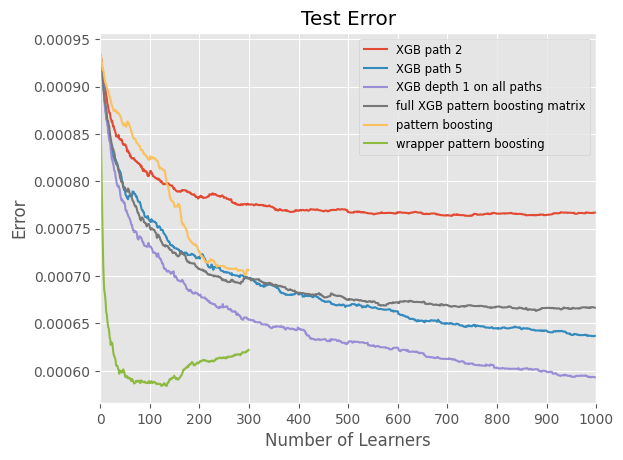

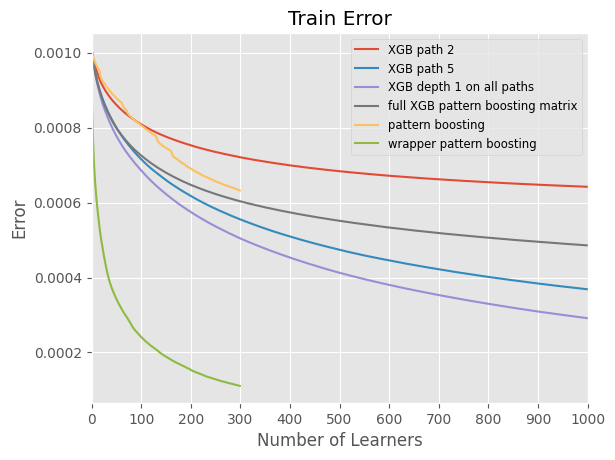

In [12]:
# load the errors
directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot", unique_subfolder=False)
errors_test_list = data_reader.load_data(directory=directory, filename="errors_test_list")
errors_train_list = data_reader.load_data(directory=directory, filename="errors_train_list")
n_learners_list = data_reader.load_data(directory=directory, filename="n_learners_list")
labels_list = data_reader.load_data(directory=directory, filename="labels_list")


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


def plot_error_evolution(error_list: List[List[float]],
                         number_of_learners_list: List[List[float]],
                         labels: List[str],
                         title: str = 'Evolution of the Error',
                         y_lim: Optional[Tuple[float, float]] = None,
                         x_lim: Optional[Tuple[float, float]] = None,
                         legend_fontsize: str = 'small') -> None:
    """
    Plots the evolution of different error series based on corresponding number of learners and error values.

    :param error_list: A list of lists, where each sublist contains the error values for a different model or condition.
    :type error_list: list[list[float]]
    :param number_of_learners_list: A list of lists of numbers representing learners that correspond to the error values.
    :type number_of_learners_list: list[list[float]]
    :param labels: A list of strings that serve as labels for the plots. Must be the same length as error_list.
    :type labels: list[str]
    :param title: The title of the plot. Defaults to 'Evolution of the Error' if not provided.
    :type title: str
    :param y_lim: An optional tuple with two float values to set the limits of the y-axis. Defaults to None if not provided.
    :type y_lim: tuple[float, float], optional
    :param x_lim: An optional tuple with two float values to set the limits of the x-axis. Defaults to None if not provided.
    :type x_lim: tuple[float, float], optional
    :param legend_fontsize: The font size of the legend text. Defaults to 'small' if not provided.
    :type legend_fontsize: str
    :return: None
    """

    if not error_list or not number_of_learners_list or not labels:
        raise ValueError("error_list, number_of_learners_list, and labels must not be empty.")

    if len(error_list) != len(labels) or len(error_list) != len(number_of_learners_list):
        raise ValueError(
            f"The number of labels ({len(labels)}) and the number of error/value series ({len(error_list)}) must match.")

    for error_values, number_of_learners_values in zip(error_list, number_of_learners_list):
        if len(error_values) != len(number_of_learners_values):
            raise ValueError("Each error sublist must be of the same length as its corresponding value sublist.")

    plt.style.use('ggplot')  # Set the plot style to 'ggplot'

    fig, ax = plt.subplots()

    for error, number_of_learners, label in zip(error_list, number_of_learners_list, labels):
        ax.plot(list(number_of_learners), list(error), label=label)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force x-axis to show only integer values

    if x_lim is not None:
        ax.set_xlim(x_lim)

    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.set_xlabel('Number of Learners')
    ax.set_ylabel('Error')
    ax.set_title(title)
    ax.legend()
    #ax.set_yscale('log')
    ax.legend(fontsize=legend_fontsize)  # Set the legend font size
    ax.grid(True)

    plt.show()

y_lim=None
x_lim=None
#y_lim = (0.00018, 0.001)
x_lim = (0, max_n_learners)

plot_error_evolution(errors_test_list, n_learners_list, labels_list, title="Test Error", y_lim=y_lim,
                     x_lim=x_lim)
plot_error_evolution(errors_train_list, n_learners_list, labels_list, title="Train Error", y_lim=y_lim,
                     x_lim=x_lim)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [10]:
errors_test_list[-2]

[]

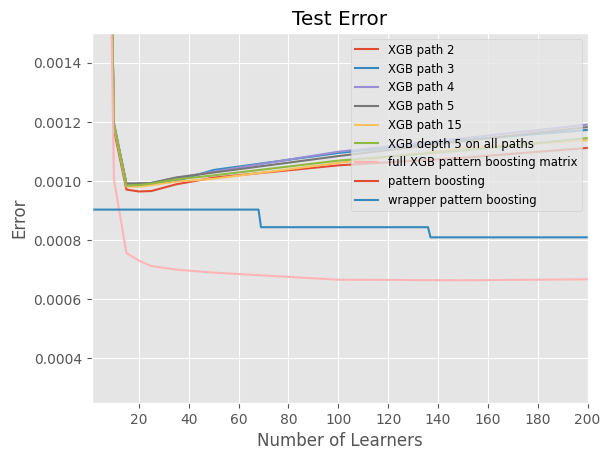

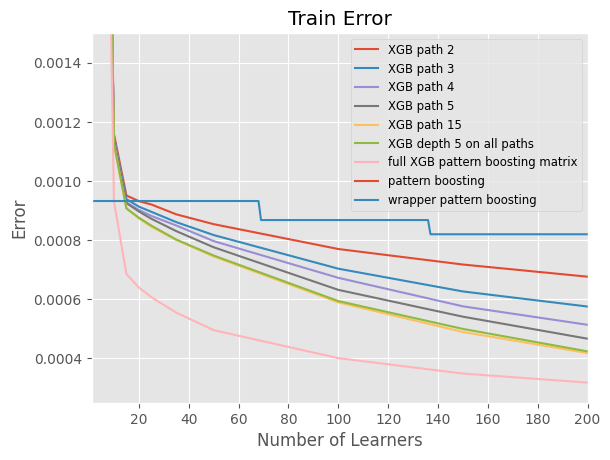

In [10]:
if True:
    # load the errors
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot/learning_rate_03",
                                              unique_subfolder=False)
    errors_test_list = data_reader.load_data(directory=directory, filename="errors_test_list")
    errors_train_list = data_reader.load_data(directory=directory, filename="errors_train_list")
    n_learners_list = data_reader.load_data(directory=directory, filename="n_learners_list")
    labels_list = data_reader.load_data(directory=directory, filename="labels_list")
# learning rate 0.3





y_lim = (0.00025, 0.0015)
x_lim = (1, 200)

plot_error_evolution(errors_test_list, n_learners_list, labels_list, title="Test Error", y_lim=y_lim,
                     x_lim=x_lim)
plot_error_evolution(errors_train_list, n_learners_list, labels_list, title="Train Error", y_lim=y_lim,
                     x_lim=x_lim)


In [ ]:
#analyze wrapper boosting
directory = data_reader.get_save_location(folder_relative_path="results",
                                          unique_subfolder=True)

wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")
synthetic_dataset = data_reader.load_data(directory=directory, filename="synthetic_dataset")

analysis = AnalysisWrapperPatternBoosting(pattern_boosting)
analysis.plot_all_analysis(n=40, synthetic_dataset=synthetic_dataset)


In [ ]:
# plot wrapper boosting analysis on syn...
if True:
    directory = data_reader.get_save_location(folder_relative_path="results",
                                              unique_subfolder=True)

    wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")
    synthetic_dataset = data_reader.load_data(directory=directory, filename="synthetic_dataset")

    analysis = AnalysisWrapperPatternBoosting(wrapper_pattern_boosting)



In [ ]:
# launch pattern boosting on syintetic dataset and see how many paths are found by number of iterations
if True:

    old_show_analysis = Settings.show_analysis
    old_maximum_number_of_steps = Settings.maximum_number_of_steps
    old_generate_new_dataset = Settings.generate_new_dataset
    old_wrapper_boosting=Settings.wrapper_boosting
    old_dataset_name=Settings.dataset_name

    Settings.show_analysis = True
    Settings.generate_new_dataset = True
    Settings.wrapper_boosting=True
    Settings.dataset_name="5k_synthetic_dataset"

    dataset = load_dataset(dataset_name='5k_synthetic_dataset')

    directory = data_reader.get_save_location(folder_relative_path="results",
                                              unique_subfolder=True)

    synthetic_dataset = data_reader.load_data(directory=directory, filename="synthetic_dataset")

    train_dataset, test_dataset = data_reader.split_training_and_test(dataset, Settings.test_size,
                                                                      random_split_seed=Settings.random_split_test_dataset_seed)
    tested_values=range(200,210,50)
    boosting_matrix_header=[[]]*len(tested_values)
    selected_paths=[[]]*len(tested_values)
    total_number_of_selsected_paths=[int]*len(tested_values)
    for i,value in enumerate(tested_values):
        print(value)
        print('-----------------------------------------------------------------')
        Settings.maximum_number_of_steps = value
        settings=Settings()
        wrapper_pattern_boosting = WrapperPatternBoosting(settings=settings)
        wrapper_pattern_boosting.train(train_dataset, test_dataset)
        boosting_matrix_header[i] = wrapper_pattern_boosting.get_boosting_matrix_header()
        selected_paths[i] = wrapper_pattern_boosting.get_selected_paths()
        total_number_of_selsected_paths[i]=len(selected_paths[i])
        del wrapper_pattern_boosting

    Settings.show_analysis = old_show_analysis
    Settings.maximum_number_of_steps = old_maximum_number_of_steps
    Settings.generate_new_dataset = old_generate_new_dataset
    Settings.wrapper_boosting = old_wrapper_boosting
    Settings.dataset_name=old_dataset_name


    n_spotted_paths=[int]*len(tested_values)
    n_header_paths=[int]*len(tested_values)
    missed_paths=[]

    for i,value in enumerate(tested_values):

        counter_spotted=0
        counter_header=0
        for path in synthetic_dataset.target_paths:
            if path in selected_paths[i]:
                counter_spotted +=1
            elif value == tested_values[-1]:
                missed_paths.append(path)
            if path in boosting_matrix_header[i]:
                counter_header+=1
        n_spotted_paths[i]=counter_spotted
        n_header_paths[i]=counter_header





In [3]:

def plot_found_paths(tested_values, correctly_found_paths, total_number_of_paths_explored):
    # Set up the plot
    plt.figure(figsize=(8,6))
    plt.title("Paths Explored vs Correct Paths")
    plt.xlabel("Number of Iterations/Selected Paths")
    plt.ylabel("Number of Target Paths found")
    # Plot the two functions
    plt.plot(tested_values, correctly_found_paths, label="Correct Paths")
    #plt.plot(tested_values, total_number_of_paths_explored, label="Explored Paths")

    # Add a legend to the plot
    plt.legend()

    # Show the plot
    plt.show()


In [4]:
tested_values=list(range(2,70,7))+ list(range(80,110,8))+list(tested_values)
total_number_of_selsected_paths=[54, 167, 280, 392, 495, 592, 667, 737, 822, 895, 1048, 1108, 1174, 1232]+total_number_of_selsected_paths
n_spotted_paths=[46, 76, 80, 85, 90, 93, 98, 101, 102, 104, 104, 104, 106, 106]+n_spotted_paths

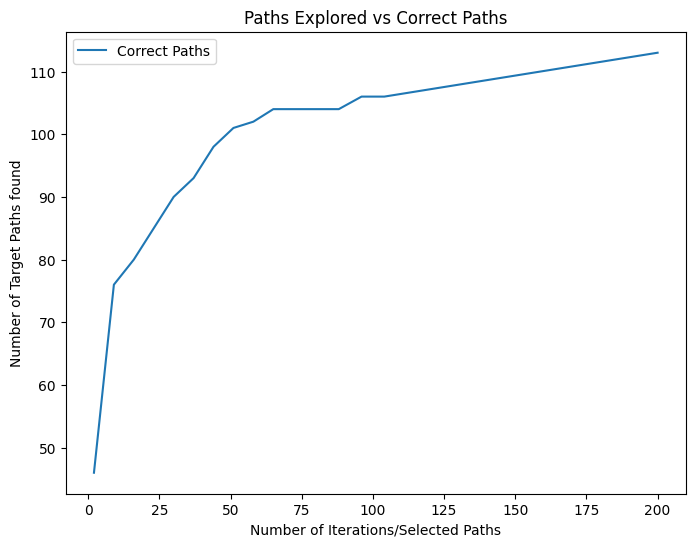

In [5]:
plot_found_paths(tested_values,n_spotted_paths,total_number_of_selsected_paths)

ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

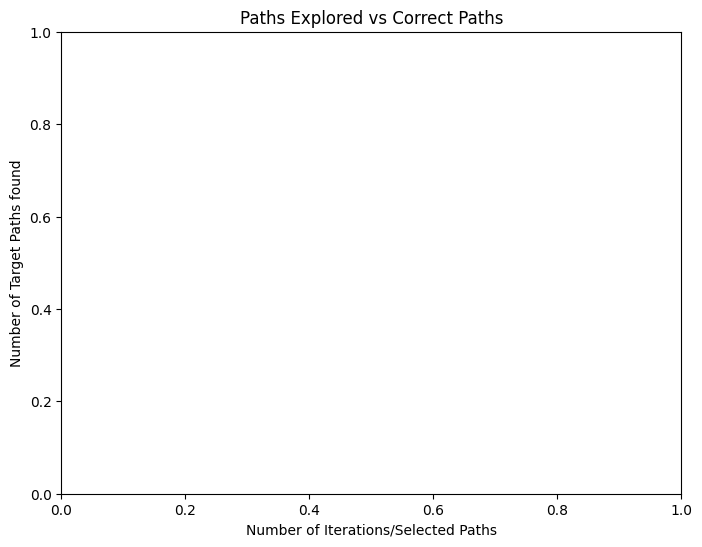

In [6]:
plot_found_paths(tested_values,n_header_paths,total_number_of_selsected_paths)

In [ ]:
n_header_paths

In [ ]:
n_spotted_paths

In [ ]:
total_number_of_selsected_paths


In [ ]:
# create frequency matrix of synthetic dataset
matrix = synthetic_dataset.number_paths_counting
header = synthetic_dataset.target_paths
boosting_dataframe = pd.DataFrame(matrix,columns=header)


In [11]:
directory = data_reader.get_save_location(folder_relative_path="results",
                                              unique_subfolder=True)
print(directory)
synthetic_dataset = data_reader.load_data(directory=directory, filename="synthetic_dataset")

/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_100_max_path_length_100_5_k_selection_graphs/wrapped_boosting/


In [12]:
import pandas as pd

def highest_corr(df, col_names):
    highest_correlations = {}
    corr_matrix = df.corr()
    for col_name in col_names:
        if col_name in corr_matrix.columns:
            corr_values = corr_matrix[col_name]
            corr_values = corr_values[corr_values.index != col_name] # exclude self-correlation
            absolute_corr_values = corr_values.abs() # consider absolute correlation
            highest_corr_coef = max(absolute_corr_values)
            highest_correlations[col_name] = highest_corr_coef
    return highest_correlations


In [13]:
highest_corr(boosting_dataframe,missed_paths)

{(80, 7, 7): 0.44937048253671213,
 (39, 6, 5): 1.0,
 (39, 6, 7): 1.0,
 (28, 7, 6, 6, 17): 0.36536110254418724,
 (28, 7, 16): 0.5772347644832214,
 (28, 7, 6, 15): 0.10348882385695721,
 (21, 7, 14): 0.3157148766181184,
 (28, 7, 7, 7): 0.2493995196156926,
 (28, 7, 7, 16): 0.5772347644832214,
 (57, 7, 7): 0.4421713289349044,
 (28, 7, 6, 6, 9): 0.7253731164947935,
 (28, 7, 6, 16): 0.35104192820468694,
 (28, 17): 0.28603128371792974,
 (28, 35): 0.28534888689620763,
 (28, 7, 6, 6, 6, 17): 0.25754670375141187}

In [14]:
len(missed_paths)

15

{}

Old version analysis not split

In [ ]:
# Load the dataset with the matrix with all possible paths

directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_all_paths")

dataset = load_dataset(dataset_name)

# get the frequency matrix
print("get the frequency matrix")
frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                columns=pattern_boosting.boosting_matrix.get_header())

print(len(pattern_boosting.boosting_matrix.get_header()))

# run classical XGB with depth 1 using different number of learners, parallelize over the max length paths
print("run classical XGB with depth 1 using different number of learners")
pool = ThreadPool(min(10, len(max_path_length)))

xgb_err = pool.map(
    functools.partial(get_XGB_error_and_variable_importance,
                      frequency_matrix=copy.deepcopy(frequency_matrix),
                      labels=dataset.labels,
                      max_number_of_learners=number_of_learners),
    max_path_length)

xgb_test_err, xgb_train_err = zip(*xgb_err)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Run xgb full power and on the frequency matrix with all possible paths
print("Run xgb full power and on the frequency matrix with all possible paths")
xgb_settings = Settings.xgb_model_parameters
xgb_settings['max_depth'] = max_depth
test_err_full_power_xgb, train_err_full_power_xgb = get_XGB_error_and_variable_importance(
    max_path_length=200,
    frequency_matrix=copy.deepcopy(frequency_matrix),
    labels=dataset.labels,
    max_number_of_learners=number_of_learners,
    xgb_settings=xgb_settings)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Run xgb full power and on the frequency matrix given by pattern boosting
print("Run xgb full power and on the frequency matrix given by pattern boosting")
# load pattern boosting model, to use the headers found by the algorithm
directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_300_steps")
print(pattern_boosting.test_dataset)

pd_pattern_boosting_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                          columns=pattern_boosting.boosting_matrix.get_header())

test_err_full_power_xgb_on_pattern_boosting_matrix, train_err_full_power_xgb_on_pattern_boosting_matrix = get_XGB_error_and_variable_importance_t(
    max_path_length=200,
    pattern_boosting=pattern_boosting,
    max_number_of_learners=number_of_learners,
    frequency_matrix=pd_pattern_boosting_matrix,
    xgb_settings=xgb_settings)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#merging all the errors

errors_test_list += xgb_test_err
errors_train_list += xgb_train_err
for length in max_path_length:
    n_learners_list.append(number_of_learners)
    labels_list.append('XGB path ' + str(length))

errors_test_list.append(test_err_full_power_xgb)
errors_train_list.append(train_err_full_power_xgb)
n_learners_list.append(number_of_learners)
labels_list.append('XGB depth ' + str(max_depth) + ' on all paths')

errors_test_list.append(test_err_full_power_xgb_on_pattern_boosting_matrix)
errors_train_list.append(train_err_full_power_xgb_on_pattern_boosting_matrix)
n_learners_list.append(number_of_learners)
labels_list.append('XGB pattern boosting matrix')
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


errors_test_list.append(pattern_boosting.test_error)
errors_train_list.append(pattern_boosting.train_error)
n_learners_list.append(range(1, len(pattern_boosting.test_error) + 1))
labels_list.append('pattern boosting')
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_300_max_path_length_100_5_k_selection_graphs/wrapped_boosting/'

wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")

errors_test_list.append(wrapper_pattern_boosting.test_error)
errors_train_list.append(wrapper_pattern_boosting.train_error)
n_learners_list.append(range(1, len(wrapper_pattern_boosting.test_error) + 1))
labels_list.append('wrapper pattern boosting')

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# saving the errors
try:
    old_n_learners = data_reader.load_data(directory="results/jupiter/plot", filename="old_n_learners")
except:
    warnings.warn("Old number of learners not found")
    old_n_learners = 0
if max_n_learners >= old_n_learners:
    data_reader.save_data(max_n_learners, filename="old_n_learners", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(errors_test_list, filename="errors_test_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(errors_train_list, filename="errors_train_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(n_learners_list, filename="n_learners_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(labels_list, filename="labels_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




Run xgb full power and on the frequency matrix given by pattern boosting
Average value of label: 0.15584368
Dataset dimension: 1000

Setting up matrix ready
Frequency matrix ready
Learner number:  1
Learner number:  2
Learner number:  5
Learner number:  7
Learner number:  10
Learner number:  15
Learner number:  20
Learner number:  25
Learner number:  35
Learner number:  50
Learner number:  100
Learner number:  150
Learner number:  200
max path length:  200
max path length:  200
max path length:  200


In [ ]:
# load the errors
directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot", unique_subfolder=False)
errors_test_list = data_reader.load_data(directory=directory, filename="errors_test_list")
errors_train_list = data_reader.load_data(directory=directory, filename="errors_train_list")
n_learners_list = data_reader.load_data(directory=directory, filename="n_learners_list")
labels_list = data_reader.load_data(directory=directory, filename="labels_list")

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import List, Tuple, Optional

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import List, Tuple, Optional


def plot_error_evolution(error_list: List[List[float]],
                         number_of_learners_list: List[List[float]],
                         labels: List[str],
                         title: str = 'Evolution of the Error',
                         y_lim: Optional[Tuple[float, float]] = None,
                         x_lim: Optional[Tuple[float, float]] = None,
                         legend_fontsize: str = 'small') -> None:
    """
    Plots the evolution of different error series based on corresponding number of learners and error values.

    :param error_list: A list of lists, where each sublist contains the error values for a different model or condition.
    :type error_list: list[list[float]]
    :param number_of_learners_list: A list of lists of numbers representing learners that correspond to the error values.
    :type number_of_learners_list: list[list[float]]
    :param labels: A list of strings that serve as labels for the plots. Must be the same length as error_list.
    :type labels: list[str]
    :param title: The title of the plot. Defaults to 'Evolution of the Error' if not provided.
    :type title: str
    :param y_lim: An optional tuple with two float values to set the limits of the y-axis. Defaults to None if not provided.
    :type y_lim: tuple[float, float], optional
    :param x_lim: An optional tuple with two float values to set the limits of the x-axis. Defaults to None if not provided.
    :type x_lim: tuple[float, float], optional
    :param legend_fontsize: The font size of the legend text. Defaults to 'small' if not provided.
    :type legend_fontsize: str
    :return: None
    """

    if not error_list or not number_of_learners_list or not labels:
        raise ValueError("error_list, number_of_learners_list, and labels must not be empty.")

    if len(error_list) != len(labels) or len(error_list) != len(number_of_learners_list):
        raise ValueError(
            f"The number of labels ({len(labels)}) and the number of error/value series ({len(error_list)}) must match.")

    for error_values, number_of_learners_values in zip(error_list, number_of_learners_list):
        if len(error_values) != len(number_of_learners_values):
            raise ValueError("Each error sublist must be of the same length as its corresponding value sublist.")

    plt.style.use('ggplot')  # Set the plot style to 'ggplot'

    fig, ax = plt.subplots()

    for error, number_of_learners, label in zip(error_list, number_of_learners_list, labels):
        ax.plot(number_of_learners, error, label=label)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force x-axis to show only integer values

    if x_lim is not None:
        ax.set_xlim(x_lim)

    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.set_xlabel('Number of Learners')
    ax.set_ylabel('Error')
    ax.set_title(title)
    ax.legend()
    ax.legend(fontsize=legend_fontsize)  # Set the legend font size
    ax.grid(True)

    plt.show()


y_lim = (0.00025, 0.0015)
x_lim = (5, 300)

plot_error_evolution(errors_test_list, n_learners_list, labels_list, title="Test Error", y_lim=y_lim,
                     x_lim=x_lim)
plot_error_evolution(errors_train_list, n_learners_list, labels_list, title="Train Error", y_lim=y_lim,
                     x_lim=x_lim)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



run classical XGB with depth 1 using different number of learners
get the frequency matrix
98563
run classical XGB with depth 1 using different number of learners
Learner number:  1
Learner number: Learner number:  1
 1
Learner number:  1
Learner number:  1
Learner number:  2
Learner number:  2
Learner number:  2
Learner number:  5
Learner number:  5
Learner number:  2
Learner number:  7
Learner number:  5
Learner number:  7
Learner number:  10
Learner number:  7
Learner number:  5
Learner number:  10
Learner number:  15
Learner number:  10
Learner number:  7
Learner number:  15
Learner number:  20
Learner number:  15
Learner number:  10
Learner number:  20
Learner number:  25
Learner number:  35
Learner number:  20
Learner number:  25
Learner number:  15
Learner number:  50
Learner number:  35
Learner number:  25
Learner number:  20
Learner number:  100
Learner number:  50
Learner number:  35
Learner number:  25
Learner number:  2
Learner number:  100
Learner number:  150
Learner numb